# Joint inversion of three different electromagnetic data sets

## Purpose
By jointly inverting three different types of electromagnetic (EM) data sets, we recover a single conductivity model. We designed that each of EM surveys has different sensitivity to the the earth conductivity structure and hence joint inversion of them can help to resolve conductivity structure better than inverting each of data sets separately.  

## Three different EM data sets
- Frequency domain airboren EM survey (Resolve)
- Time domain airboren EM survey (Geotem)
- Time domain surface loop (or ground loop) EM survey (NanoTEM)


<img src="joint_sparse.png" width=200px></img>

In [1]:
from SimPEG import Mesh, Maps, Utils
from simpegEM1D import (
    get_vertical_discretization_frequency, EM1DSurveyFD,
    get_vertical_discretization_time, EM1DSurveyTD, Utils1D,
    EM1D, set_mesh_1d, get_geotem_wave, get_nanotem_wave
)
from scipy.constants import mu_0
import numpy as np
%pylab inline

frequency_mesh = np.array([100., 382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency_mesh, sigma_background=0.01, factor_fmax=5, n_layer=40)

mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
n_layer = mesh1D.nC

sig_half = 1e-1
sig_layer_1 = 1e0
sig_layer_2 = 1e-2
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)
sig  = np.ones(n_layer)*sig_half
layer_ind_1 = (-150>LocSigZ) & (-200<LocSigZ)
sig[layer_ind_1] = sig_layer_1
layer_ind_2 = (-10>LocSigZ) & (-30<LocSigZ)
sig[layer_ind_2] = sig_layer_2
m_true = np.r_[np.log(sig)]

Populating the interactive namespace from numpy and matplotlib


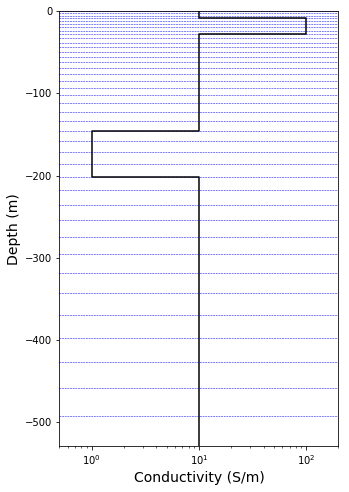

In [2]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=True)

In [3]:
def get_FD_survey_problem(sigmaMap):
    frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
    FDsurvey = EM1DSurveyFD(
        rx_location = np.array([0., 0., 30.]),
        src_location = np.array([0., 0., 30.]),
        field_type = 'secondary',
        rx_type = 'Hz',
        src_type = 'VMD',
        offset = np.ones(5)*7.86,
        topo = np.r_[0., 0., 0.],
        depth = depth,
        frequency = frequency
    )
    prob = EM1D(
        mesh1D, sigmaMap=sigmaMap,
        chi= np.zeros(FDsurvey.n_layer),
        verbose=False
    )
    if prob.ispaired:
        prob.unpair()
    if FDsurvey.ispaired:
        FDsurvey.unpair()
    prob.pair(FDsurvey)     
    return FDsurvey, prob

def get_TD_survey_problem(sigmaMap, survey_type='airborne'):
    if survey_type == 'airborne':
        time_input_currents, input_currents = get_geotem_wave(4000*1e-6)
        time = np.logspace(-4, -2, 21)
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 120]),
            src_location = np.array([0., 0., 120-45]),
            topo = np.r_[0., 0., 0.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'VMD',
            offset = np.array([120.]),
            time = time,
            time_input_currents=time_input_currents,
            input_currents=input_currents,
            n_pulse = 2,
            base_frequency = 30.
        )
    elif survey_type == 'ground':
        time_input_currents, input_currents = get_nanotem_wave(5e-6)
        time = np.logspace(-6, -3, 21)
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 0]),
            src_location = np.array([0., 0., 0]),
            topo = np.r_[0., 0., 0.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'CircularLoop',
            a = 20,
            time = time,
            time_input_currents=time_input_currents,
            input_currents=input_currents,
            n_pulse = 2,
            base_frequency = 30.  
        )
    prob = EM1D(mesh1D, sigmaMap=sigmaMap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    return TDsurvey, prob

In [4]:
survey_fd, prob_fd = get_FD_survey_problem(expmap)
survey_td, prob_td = get_TD_survey_problem(expmap)
survey_td_ground, prob_td_ground = get_TD_survey_problem(expmap, survey_type='ground')

In [5]:
from SimPEG import DataMisfit

In [6]:
std = 0.05
survey_fd.dobs = survey_fd.dpred(m_true)
survey_td.dobs = survey_td.dpred(m_true)
survey_td_ground.dobs = survey_td_ground.dpred(m_true)

dmisfit_fd = DataMisfit.l2_DataMisfit(survey_fd)
dmisfit_td = DataMisfit.l2_DataMisfit(survey_td)
dmisfit_td_ground = DataMisfit.l2_DataMisfit(survey_td_ground)

dmisfit_fd.W = 1./(abs(survey_fd.dobs)*0.07)
dmisfit_td.W = 1./(abs(survey_td.dobs)*std)
dmisfit_td_ground.W = 1./(abs(survey_td_ground.dobs)*std)
dmisfit = dmisfit_td + dmisfit_fd + dmisfit_td_ground

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [7]:
from SimPEG import Regularization, Optimization, Directives, Inversion, InvProblem
def run_inversion(dmisfit, use_sparse=False):
    reg = Regularization.Sparse(
        mesh1D, mapping=Maps.IdentityMap(mesh1D)
    )
    m0 = np.ones_like(m_true)*np.log(sig_half)
    p=0.
    qx, qz = 2., 2.
    reg.norms = np.c_[p, qx, qz, 0.]
    IRLS = Directives.Update_IRLS(
        maxIRLSiter=10, minGNiter=1, fix_Jmatrix=False, coolingRate=2, 
        betaSearch=False,
        chifact_start = 1.
    )
    opt = Optimization.ProjectedGNCG(maxIter = 30)
    opt.maxIterLS = 5
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
    target = Directives.TargetMisfit()
    if use_sparse:
        inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
    else:
        inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])        
    opt.LSshorten = 0.5
    opt.remember('xc')
    mopt = inv.run(m0)
    return mopt, invProb.dpred

In [8]:
mopt_fd, dpred_fd = run_inversion(dmisfit_fd, use_sparse=False)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.40e+00  9.13e+01  0.00e+00  9.13e+01    1.40e+02      0              
   1  7.40e+00  7.92e+00  9.38e-01  1.49e+01    7.57e+00      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 9.2300e+00
1 : |xc-x_last| = 2.6709e-01 <= tolX*(1+|x0|) = 1.5563e+00
0 : |proj(x-g)-x|    = 7.5652e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.5652e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      30    <= iter          =      2
-----------------------

In [9]:
mopt_td, dpred_td = run_inversion(dmisfit_td, use_sparse=False)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.90e+01  2.33e+03  0.00e+00  2.33e+03    1.63e+03      0              
   1  6.90e+01  2.99e+02  2.95e+00  5.03e+02    1.69e+02      0              
   2  3.45e+01  1.60e+02  3.98e+00  2.98e+02    1.02e+02      0   Skip BFGS  
   3  3.45e+01  8.90e+01  5.31e+00  2.72e+02    1.45e+01      0   Skip BFGS  
   4  1.73e+01  8.44e+01  5.38e+00  1.77e+02    6.06e+01      0              
   5  1.73e+01  6.18e+01  6.14e+00  1.68e+02    4.08e+01      0              
   6  8.63e+00  4.86e+01  6.66e+00  1.06e+02    6.28e+01      0   

In [10]:
mopt_td_ground, dpred_td_ground = run_inversion(dmisfit_td_ground, use_sparse=False)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.14e+02  2.68e+03  0.00e+00  2.68e+03    4.69e+03      0              
   1  2.14e+02  4.53e+02  5.15e-01  5.63e+02    5.94e+02      0              
   2  1.07e+02  1.49e+02  1.08e+00  2.65e+02    2.12e+02      0   Skip BFGS  
   3  1.07e+02  8.10e+01  1.53e+00  2.45e+02    1.71e+01      0   Skip BFGS  
   4  5.34e+01  8.60e+01  1.48e+00  1.65e+02    9.64e+01      0              
   5  5.34e+01  6.98e+01  1.73e+00  1.62e+02    1.04e+02      0              
   6  2.67e+01  7.01e+01  1.66e+00  1.15e+02    1.33e+02      0   

In [11]:
mopt, dpred = run_inversion(dmisfit, use_sparse=False)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the EM1D problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.90e+01  5.10e+03  0.00e+00  5.10e+03    6.14e+03      0              
   1  6.90e+01  7.14e+02  1.67e+00  8.29e+02    7.49e+02      0              
   2  3.45e+01  2.83e+02  3.94e+00  4.19e+02    1.25e+02      0   Skip BFGS  
   3  3.45e+01  1.71e+02  5.93e+00  3.76e+02    2.92e+01      0   Skip BFGS  
   4  1.73e+01  1.60e+02  6.04e+00  2.64e+02    6.89e+01      0              
   5  1.73e+01  1.08e+02  7.68e+00  2.41e+02    4.35e+01      0              
   6  8.63e+00  8.10e+01  8.74e+00  1.56e+02    5.70e+01     

In [12]:
mopt_fd_sparse, dpred_fd_sparse = run_inversion(dmisfit_fd, use_sparse=True)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:903: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.40e+00  9.13e+01  0.00e+00  9.13e+01    1.40e+02      0              
   1  7.40e+00  7.92e+00  9.38e-01  1.49e+01    7.57e+00      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.6107852776935188 eps_q: 0.6107852776935188
Eps_p: 0.5089877314112656
Eps_q: 0.5089877314112656
delta phim:    inf
   2  7.40e+00  4.98e+00  1.53e+00  1.63e+01    4.62e+00      0   Skip BFGS  
Eps_p: 0.42415644284272136
Eps_q: 0.42415644284272136
delta phim: 1.590e+00
   3  5.01e+00  5.85e+00  1.46e+00  1.31e+01    3.74e+00      0              
Eps_p: 0.3534637023689345
Eps_q: 0.3534637023689345
delta phim: 6.988e-02
   4  7.96e+00  4.25e+00  1.77e+00  1.83e+01    8.19e+00      0    

In [13]:
mopt_td_sparse, dpred_td_sparse = run_inversion(dmisfit_td, use_sparse=True)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:903: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.90e+01  2.33e+03  0.00e+00  2.33e+03    1.63e+03      0              
   1  6.90e+01  2.99e+02  2.95e+00  5.03e+02    1.69e+02      0              
   2  3.45e+01  1.60e+02  3.98e+00  2.98e+02    1.02e+02      0   Skip BFGS  
   3  3.45e+01  8.90e+01  5.31e+00  2.72e+02    1.45e+01      0   Skip BFGS  
   4  1.73e+01  8.44e+01  5.38e+00  1.77e+02    6.06e+01      0              
   5  1.73e+01  6.18e+01  6.14e+00  1.68e+02    4.08e+01      0              
   6  8.63e+00  4.86e+01  6.66e+00  1.06e+02    6.28e+01      0              
   7  8.63e+00  2.21e+01  8.61e+00  9.64e+01    2.18e+01      0              
   8  4.31e+00  1.97e+01  8.53e+00  5.65e+01    2.13e+01      0              
   9  4.31e+00  1.08e+01

In [14]:
mopt_td_sparse, dpred_td_sparse = run_inversion(dmisfit_td, use_sparse=True)

/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:903: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.90e+01  2.33e+03  0.00e+00  2.33e+03    1.63e+03      0              
   1  6.90e+01  2.99e+02  2.95e+00  5.03e+02    1.69e+02      0              
   2  3.45e+01  1.60e+02  3.98e+00  2.98e+02    1.02e+02      0   Skip BFGS  
   3  3.45e+01  8.90e+01  5.31e+00  2.72e+02    1.45e+01      0   Skip BFGS  
   4  1.73e+01  8.44e+01  5.38e+00  1.77e+02    6.06e+01      0              
   5  1.73e+01  6.18e+01  6.14e+00  1.68e+02    4.08e+01      0              
   6  8.63e+00  4.86e+01  6.66e+00  1.06e+02    6.28e+01      0   

In [15]:
mopt_td_ground_sparse, dpred_td_ground_sparse = run_inversion(dmisfit_td_ground, use_sparse=True)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:903: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.14e+02  2.68e+03  0.00e+00  2.68e+03    4.69e+03      0              
   1  2.14e+02  4.53e+02  5.15e-01  5.63e+02    5.94e+02      0              
   2  1.07e+02  1.49e+02  1.08e+00  2.65e+02    2.12e+02      0   Skip BFGS  
   3  1.07e+02  8.10e+01  1.53e+00  2.45e+02    1.71e+01      0   Skip BFGS  
   4  5.34e+01  8.60e+01  1.48e+00  1.65e+02    9.64e+01      0              
   5  5.34e+01  6.98e+01  1.73e+00  1.62e+02    1.04e+02      0              
   6  2.67e+01  7.01e+01  1.66e+00  1.15e+02    1.33e+02      0              
   7  2.67e+01  6.76e+01  1.70e+00  1.13e+02    1.44e+02      1              
   8  1.34e+01  5.95e+01  1.93e+00  8.52e+01    1.46e+02      0              
   9  1.34e+01  5.64e+01

In [16]:
mopt_sparse, dpred = run_inversion(dmisfit, use_sparse=True)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the EM1D problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:903: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.90e+01  5.10e+03  0.00e+00  5.10e+03    6.14e+03      0              
   1  6.90e+01  7.14e+02  1.67e+00  8.29e+02    7.49e+02      0              
   2  3.45e+01  2.83e+02  3.94e+00  4.19e+02    1.25e+02      0   Skip BFGS  
   3  3.45e+01  1.71e+02  5.93e+00  3.76e+02    2.92e+01      0   Skip BFGS  
   4  1.73e+01  1.60e+02  6.04e+00  2.64e+02    6.89e+01      0              
   5  1.73e+01  1.08e+02  7.68e+00  2.41e+02    4.35e+01      0              
   6  8.63e+00  8.10e+01  8.74e+00  1.56e+02    5.70e+01      0              
   7  8.63e+00  4.85e+01  1.11e+01  1.44e+02    2.96e+01      0              
   8  4.31e+00  3.47e+01  1.18e+01  8.55e+01    3.12e+01      0              
Reached starting chifact

In [17]:
import matplotlib
matplotlib.rcParams['font.size'] = 18

In [18]:
# figdir = "/Users/sgkang/Dropbox/Researches/aem_workshow_2018_simpeg/images/"
figdir = ""

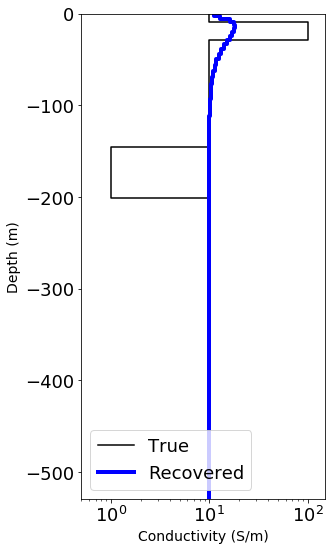

In [19]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt_fd), mesh1D,showlayers=False,ax=ax, **{'color':'b', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"resolve", dpi=200)

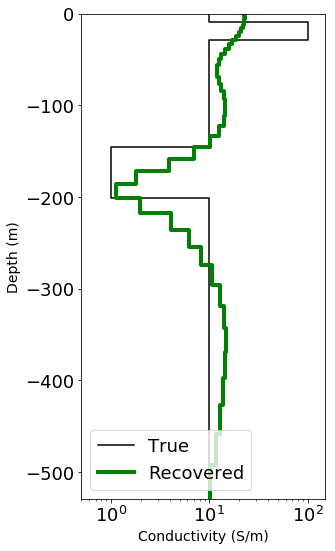

In [20]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt_td), mesh1D,showlayers=False,ax=ax, **{'color':'g', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"geotem", dpi=200)

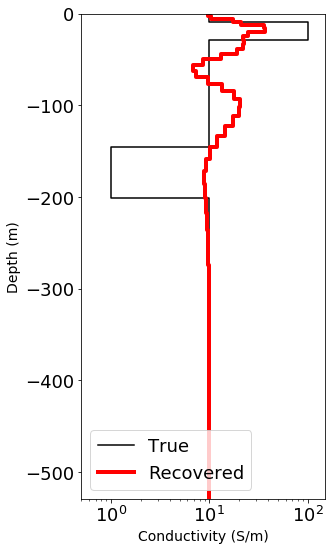

In [21]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt_td_ground), mesh1D,showlayers=False,ax=ax, **{'color':'r', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"nanotem", dpi=200)

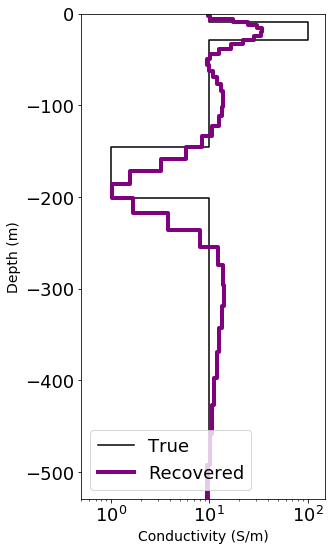

In [22]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt), mesh1D,showlayers=False,ax=ax, **{'color':'purple', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"joint", dpi=200)

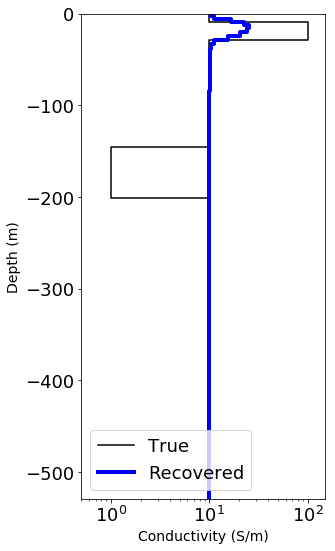

In [23]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt_fd_sparse), mesh1D,showlayers=False,ax=ax, **{'color':'b', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"resolve_sparse", dpi=200)

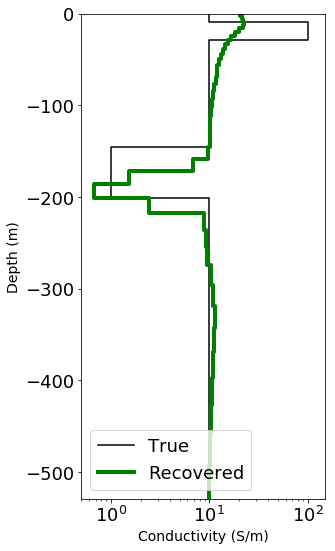

In [24]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt_td_sparse), mesh1D,showlayers=False,ax=ax, **{'color':'g', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"geotem_sparse", dpi=200)

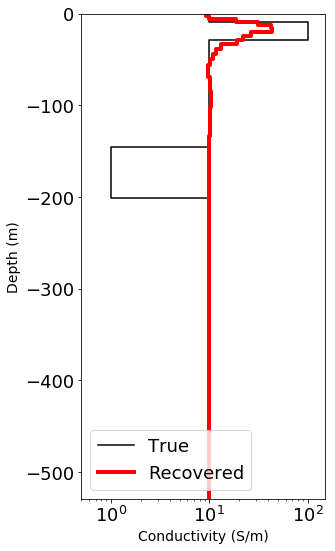

In [25]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt_td_ground_sparse), mesh1D,showlayers=False,ax=ax, **{'color':'r', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"nanotem_sparse", dpi=200)

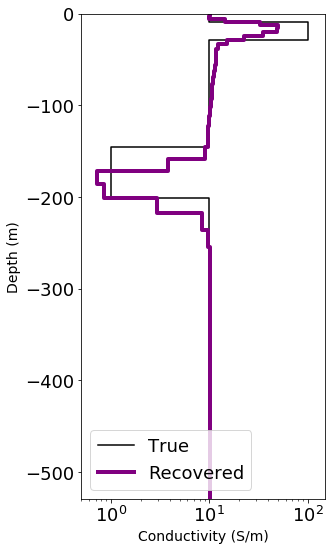

In [26]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt_sparse), mesh1D,showlayers=False,ax=ax, **{'color':'purple', 'lw':4})
plt.legend(("True", "Recovered"))
ax.set_xlim(0.5, 150)
plt.tight_layout()
fig.savefig(figdir+"joint_sparse", dpi=200)

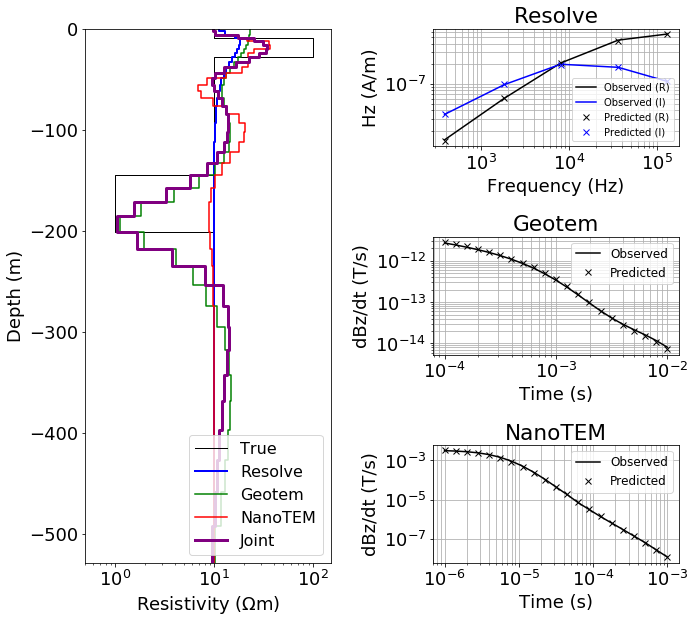

In [27]:
fig = plt.figure(figsize=(10, 9))
gs = matplotlib.gridspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[:3, 0])
Utils1D.plotLayer(1./sig, mesh1D, ax=ax0, showlayers=False, **{'lw':1})
Utils1D.plotLayer(1./(expmap*mopt_fd), mesh1D, ax=ax0, showlayers=False, **{'color':'b', 'lw':2})
Utils1D.plotLayer(1./(expmap*mopt_td), mesh1D, ax=ax0, showlayers=False, **{'color':'g'})
Utils1D.plotLayer(1./(expmap*mopt_td_ground), mesh1D, ax=ax0, showlayers=False, **{'color':'r'})
Utils1D.plotLayer(1./(expmap*mopt), mesh1D, ax=ax0, showlayers=False, **{'color':'purple', 'lw':3})
ax0.legend(('True', 'Resolve','Geotem','NanoTEM', 'Joint'), loc=4, fontsize=16)
ax0.set_xlim(0.5, 150)
ax0.set_xlabel("Resistivity ($\Omega$m)", fontsize=18)
ax0.set_ylabel("Depth (m)", fontsize=18)
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[2, 1])
ax1.loglog(survey_fd.frequency, -survey_fd.dobs[:survey_fd.n_frequency], 'k')
ax1.loglog(survey_fd.frequency, -survey_fd.dobs[survey_fd.n_frequency:], 'b')
ax1.loglog(survey_fd.frequency, -dpred[1][:survey_fd.n_frequency], 'kx')
ax1.loglog(survey_fd.frequency, -dpred[1][survey_fd.n_frequency:], 'bx')

ax2.loglog(survey_td.time, -survey_td.dobs, 'k')
ax2.loglog(survey_td.time, -dpred[0], 'kx')

ax3.loglog(survey_td_ground.time, -survey_td_ground.dobs, 'k')
ax3.loglog(survey_td_ground.time, -dpred[2], 'kx')


ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Hz (A/m)")
ax1.grid(which='both')
ax1.legend(("Observed (R)", "Observed (I)", "Predicted (R)", "Predicted (I)"), fontsize=10)
for ax in [ax2, ax3]:
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("dBz/dt (T/s)")
    ax.grid(which='both')
    ax.legend(("Observed", "Predicted"), fontsize=12)
ax1.set_title("Resolve")
ax3.set_title("NanoTEM")
ax2.set_title("Geotem")
plt.tight_layout()